*Bisono Priyambodo M*
<br>
*A11.2023.15217*

*Klasifikasi Sentimen Tweet Terhadap Kereta Cepat Whoosh Menggunakan Algoritma Machine Learning*

Kereta Cepat Whoosh merupakan salah satu proyek transportasi besar di Indonesia yang menimbulkan beragam opini masyarakat di media sosial X. Analisis sentimen publik diperlukan untuk mengetahui persepsi positif, negatif, maupun netral terhadap layanan ini.

*TUJUAN*
<br>
Mengklasifikasikan opini publik terhadap Whoosh (positif, netral, negatif).
<br>
Menganalisis performa model ML pada data sentimen yang tidak seimbang.

*IMPORT LIBRARY*

In [45]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.metrics import f1_score  # Untuk evaluasi F1-Score
from sklearn.preprocessing import LabelEncoder  # Untuk label encoding konsisten
import pickle  # Untuk menyimpan model
import string  # Untuk punctuation removal
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set style untuk plot
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

*MEMUAT DATA*

In [2]:
df = pd.read_csv("data sentimen terhadap kereta cepat di x.csv")
print("==== 5 Baris Teratas Dataset ====")
print(df.head())

==== 5 Baris Teratas Dataset ====
                                               tweet sentiment
0  jalan jalan ke bandung (cakep) pulang pulang n...  positive
1  Sebanyak 16 penari yg terbagi dalam 8 kereta m...  positive
2  PT Kereta Cepat Indonesia China (KCIC) menggel...  positive
3  Bayangin kalo dari dulu udah ada Whoosh: - Tia...  positive
4  Eh ada tau temen kantor gua PP bandung - jakar...  positive


*EDA | Exploratory Data Analysis |*

In [18]:
print("\n==== Informasi Dataset ====")
df.info()

print("\n==== Jumlah Dupilkasi ====")
print(df.duplicated().sum())

print("\n==== Jumlah Misiing Value ====")
df.isnull().sum()


==== Informasi Dataset ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              7407 non-null   object
 1   sentiment          7407 non-null   object
 2   tweet_length       7407 non-null   int64 
 3   word_count         7407 non-null   int64 
 4   hashtag_count      7407 non-null   int64 
 5   mention_count      7407 non-null   int64 
 6   url_count          7407 non-null   int64 
 7   sentiment_encoded  7407 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 463.1+ KB

==== Jumlah Dupilkasi ====
0

==== Jumlah Misiing Value ====


tweet                0
sentiment            0
tweet_length         0
word_count           0
hashtag_count        0
mention_count        0
url_count            0
sentiment_encoded    0
dtype: int64

In [17]:
# Menambahkan fitur numerik untuk analisis
df['tweet_length'] = df['tweet'].str.len()
df['word_count'] = df['tweet'].str.split().str.len()
df['hashtag_count'] = df['tweet'].str.count('#')
df['mention_count'] = df['tweet'].str.count('@')
df['url_count'] = df['tweet'].str.count('http')

# Encoding sentiment untuk analisis numerik
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_mapping)

print("\n==== Fitur Numerik yang Ditambahkan ====")
print("- tweet_length: Panjang karakter tweet")
print("- word_count: Jumlah kata dalam tweet")
print("- hashtag_count: Jumlah hashtag")
print("- mention_count: Jumlah mention (@username)")
print("- url_count: Jumlah URL")
print("- sentiment_encoded: Sentiment dalam bentuk numerik (1=positive, 0=neutral, -1=negative)")


==== Fitur Numerik yang Ditambahkan ====
- tweet_length: Panjang karakter tweet
- word_count: Jumlah kata dalam tweet
- hashtag_count: Jumlah hashtag
- mention_count: Jumlah mention (@username)
- url_count: Jumlah URL
- sentiment_encoded: Sentiment dalam bentuk numerik (1=positive, 0=neutral, -1=negative)


In [10]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
print("==== Statistik Deskriptif Numerik ====")
print(df[numerical_features].describe())

==== Statistik Deskriptif Numerik ====
       tweet_length   word_count  hashtag_count  mention_count    url_count  \
count   7407.000000  7407.000000    7407.000000    7407.000000  7407.000000   
mean     144.636020    20.990549       0.244228       0.186850     0.517888   
std       77.889813    11.817905       0.964198       0.607519     0.557203   
min       10.000000     2.000000       0.000000       0.000000     0.000000   
25%       84.000000    12.000000       0.000000       0.000000     0.000000   
50%      124.000000    18.000000       0.000000       0.000000     0.000000   
75%      206.000000    30.000000       0.000000       0.000000     1.000000   
max      326.000000    62.000000      16.000000      15.000000     4.000000   

       sentiment_encoded  
count        7407.000000  
mean            0.007830  
std             0.816845  
min            -1.000000  
25%            -1.000000  
50%             0.000000  
75%             1.000000  
max             1.000000  


In [11]:
categorical_features = df.loc[:, (df.dtypes == object)].columns.tolist()
print("==== Statistik Deskriptif Categorical ====")
print(df[categorical_features].describe())

==== Statistik Deskriptif Categorical ====
                                                    tweet sentiment
count                                                7407      7407
unique                                               7406         3
top     Pengumuman untuk Sobat Whoosh yang akan NgeWho...  positive
freq                                                    2      2500


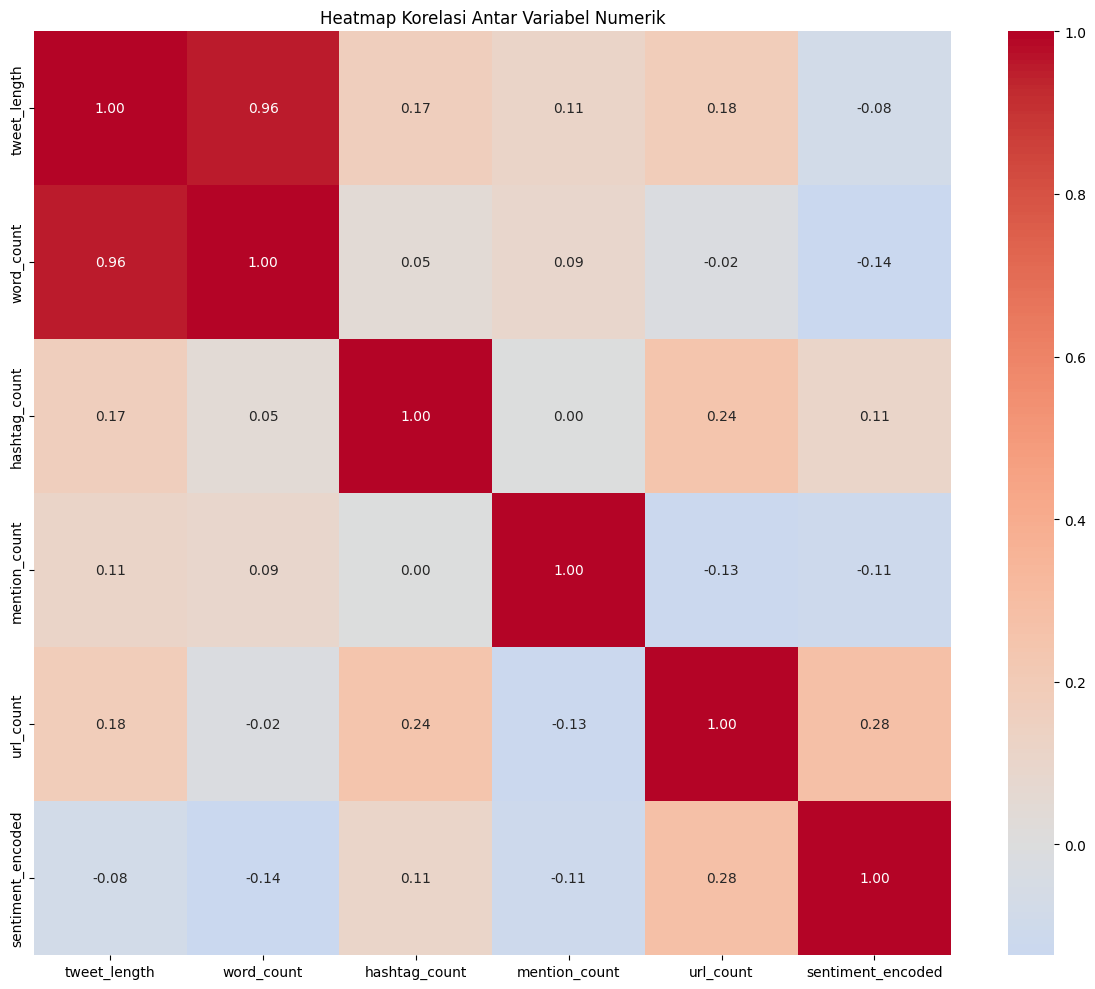

In [12]:
# Pastikan numerical_features sudah didefinisikan
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# === Heatmap Korelasi Numerik ===
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.tight_layout()
plt.show()

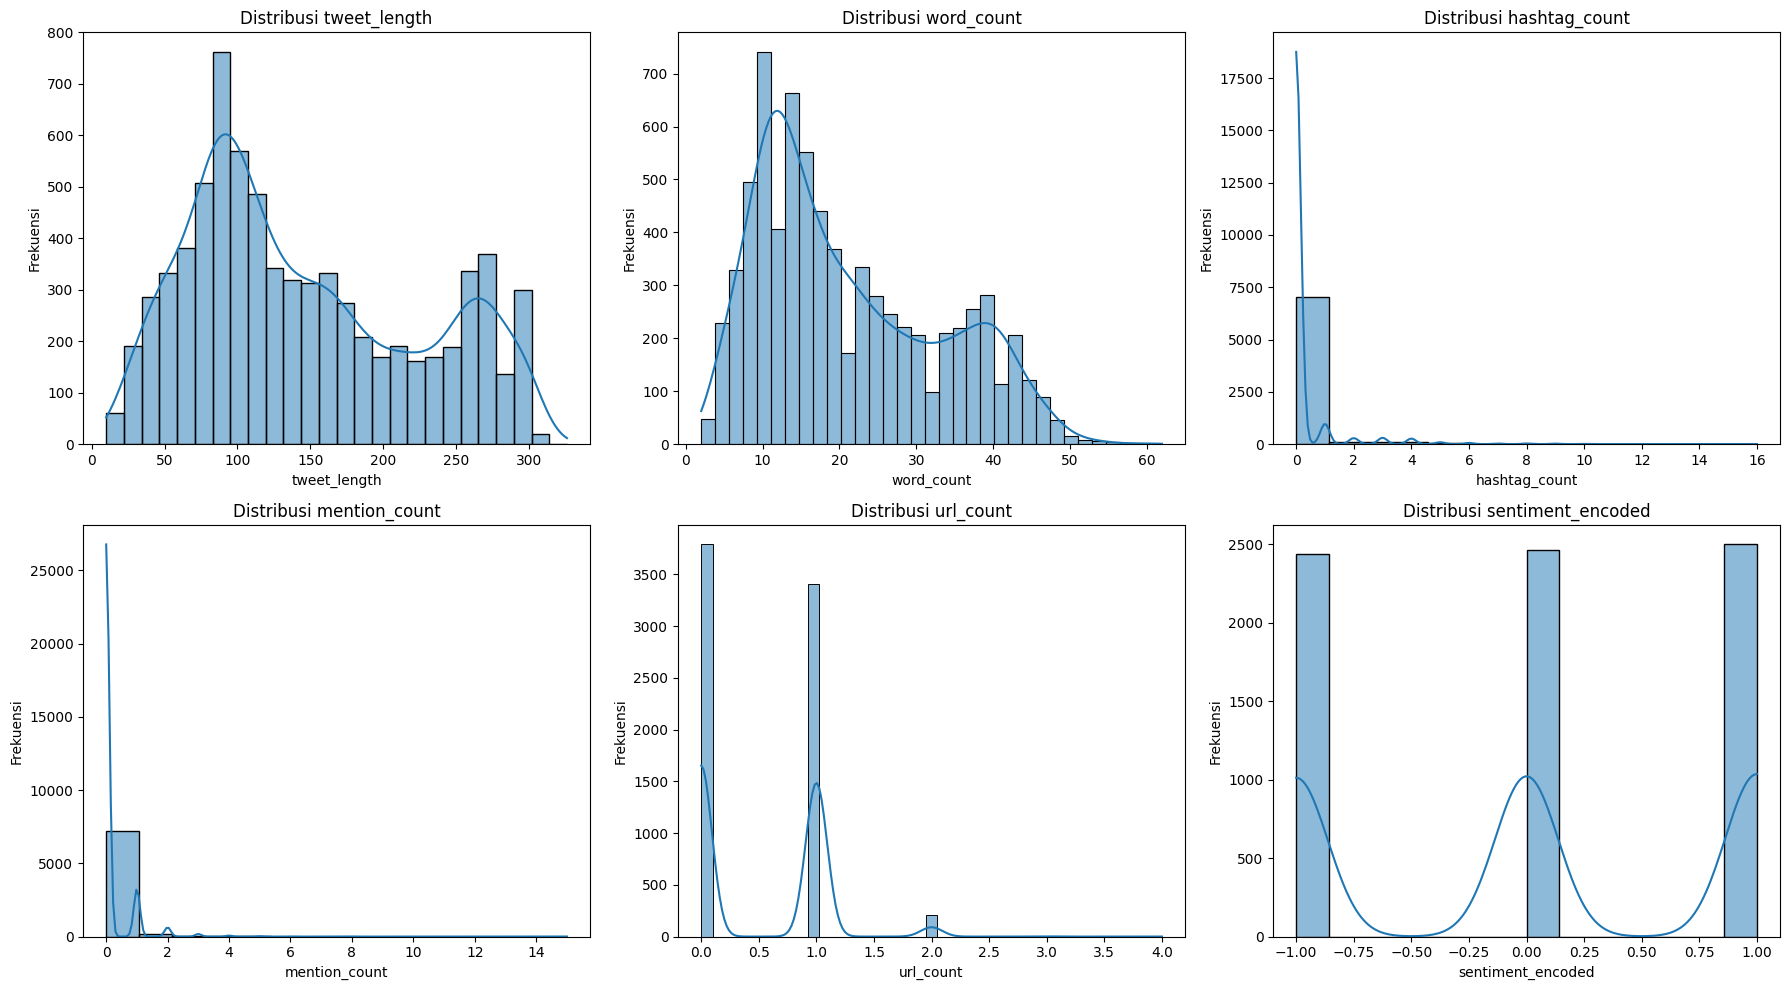

In [13]:
# Pastikan numerical_features sudah didefinisikan
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# === Visualisasi Numerik ===
num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frekuensi')

# Hapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

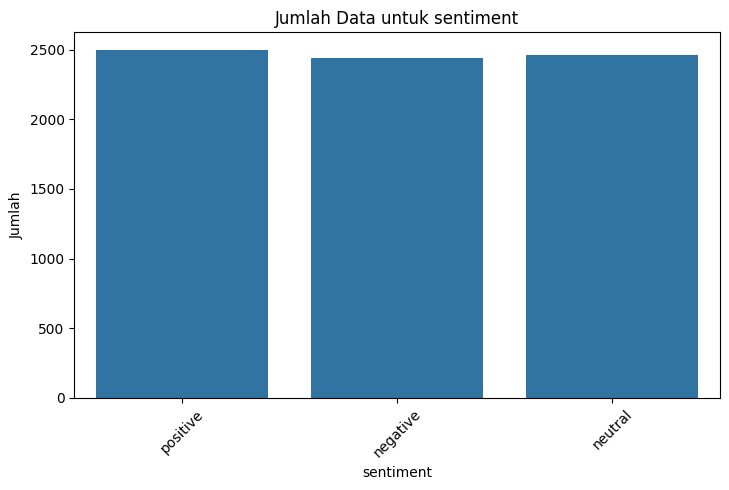

In [15]:
# Pastikan categorical_features sudah didefinisikan
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Filter hanya kolom kategorikal dengan jumlah kategori < 30 (agar plot tidak error)
categorical_features_plot = [col for col in categorical_features if df[col].nunique() < 30]

if len(categorical_features_plot) == 0:
    print("Tidak ada fitur kategorikal yang cocok untuk divisualisasikan dengan countplot.")
else:
    cat_cols = 2
    cat_rows = (len(categorical_features_plot) + cat_cols - 1) // cat_cols
    fig, axes = plt.subplots(cat_rows, cat_cols, figsize=(14, 5 * cat_rows))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features_plot):
        sns.countplot(x=feature, data=df, ax=axes[i])
        axes[i].set_title(f'Jumlah Data untuk {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Jumlah')
        axes[i].tick_params(axis='x', rotation=45)

    # Hapus subplot kosong jika ada
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

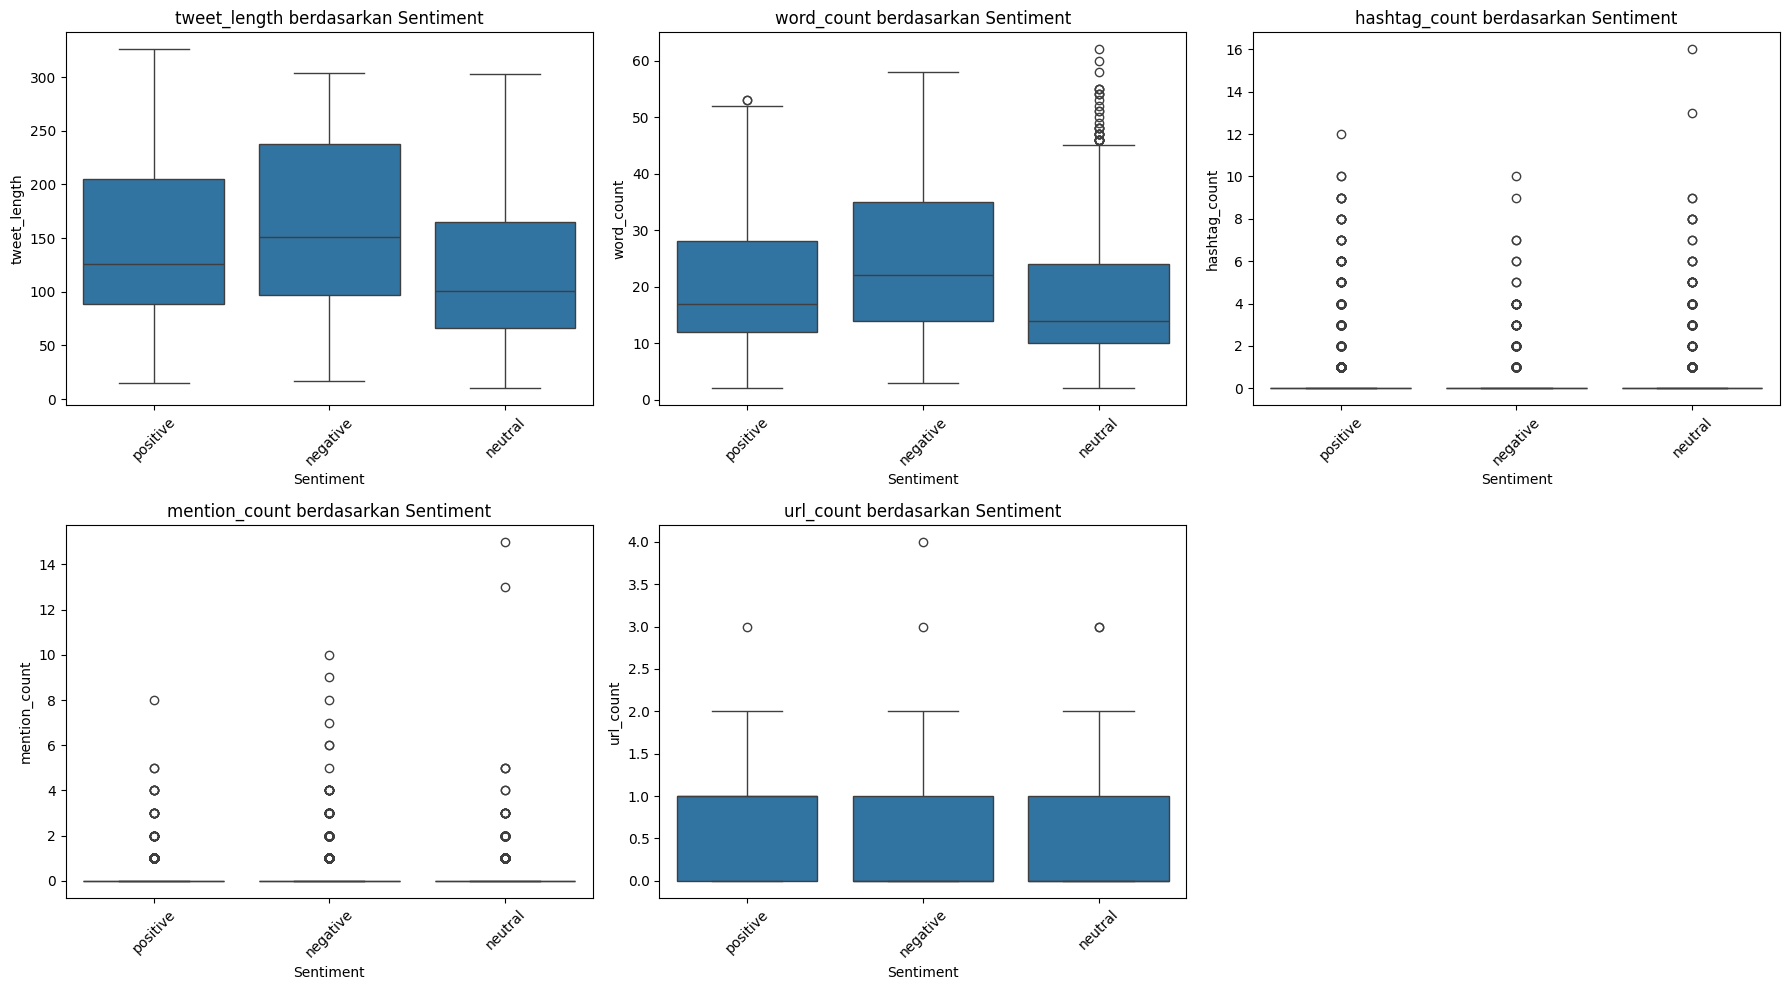

In [19]:
# Pastikan fitur-fitur berikut sudah ada di dataframe
features_to_plot = ['tweet_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count']

# Filter fitur yang benar-benar ada di df (untuk menghindari error jika ada yang belum dibuat)
features_to_plot = [f for f in features_to_plot if f in df.columns]

n_plot = len(features_to_plot)
n_cols = 3
n_rows = (n_plot + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='sentiment', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} berdasarkan Sentiment')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='x', rotation=45)

# Hapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

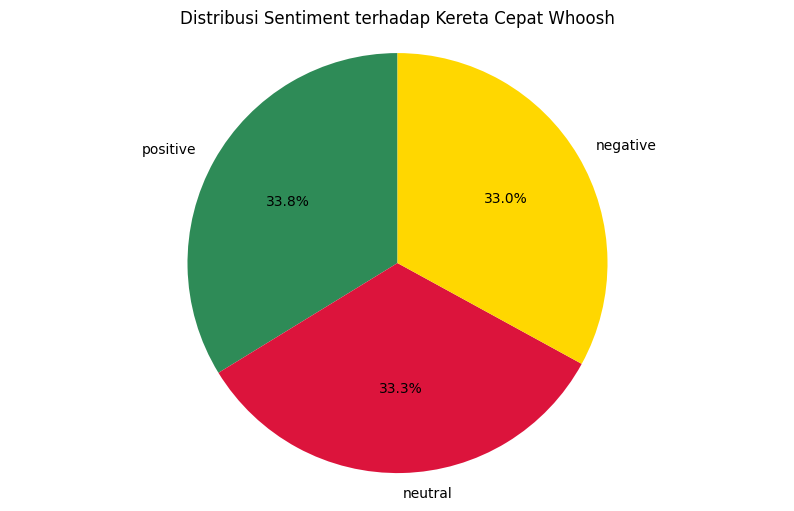


==== Ringkasan Distribusi Sentiment ====
positive: 2500 tweet (33.8%)
neutral: 2465 tweet (33.3%)
negative: 2442 tweet (33.0%)


In [20]:
# === Distribusi Sentiment ===
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment'].value_counts()
colors = ['#2E8B57', '#DC143C', '#FFD700']  # Green, Red, Gold

plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=colors[:len(sentiment_counts)],  # pastikan jumlah warna sesuai jumlah kategori
    startangle=90
)
plt.title('Distribusi Sentiment terhadap Kereta Cepat Whoosh')
plt.axis('equal')
plt.show()

print("\n==== Ringkasan Distribusi Sentiment ====")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{sentiment}: {count} tweet ({percentage:.1f}%)")

*DATA PROCESSING*

In [48]:
print("==== Setup Stopwords Indonesia ====")
try:
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    stopwords_id = StopWordRemoverFactory().get_stop_words()
    print("✓ Sastrawi berhasil diimport")
except ImportError:
    print("⚠ Sastrawi tidak tersedia, menggunakan stopwords manual")
    # Stopwords manual untuk bahasa Indonesia
    stopwords_id = [
        'yang', 'dan', 'di', 'ke', 'dari', 'untuk', 'dengan', 'ini', 'itu', 'atau',
        'juga', 'bisa', 'akan', 'sudah', 'belum', 'tidak', 'ada', 'saya', 'kamu',
        'mereka', 'kami', 'kita', 'dia', 'mereka', 'saya', 'aku', 'anda', 'saudara',
        'tuan', 'nyonya', 'nona', 'pak', 'bu', 'mas', 'mbak', 'bang', 'sis', 'bro',
        'sist', 'gan', 'gan', 'banget', 'sekali', 'sangat', 'amat', 'terlalu',
        'lebih', 'kurang', 'hampir', 'hanya', 'cuma', 'saja', 'lagi', 'masih',
        'sudah', 'pernah', 'belum', 'akan', 'mau', 'ingin', 'harus', 'boleh',
        'bisa', 'dapat', 'mampu', 'usah', 'jangan', 'tidak', 'bukan', 'tanpa',
        'dengan', 'oleh', 'karena', 'sebab', 'jika', 'kalau', 'apabila', 'ketika',
        'saat', 'waktu', 'sebelum', 'sesudah', 'setelah', 'sampai', 'hingga',
        'dalam', 'pada', 'ke', 'dari', 'untuk', 'kepada', 'terhadap', 'tentang',
        'mengenai', 'soal', 'masalah', 'hal', 'perkara', 'urusan', 'kerja',
        'pekerjaan', 'tugas', 'fungsi', 'peran', 'tujuan', 'sasaran', 'target',
        'hasil', 'hasilnya', 'akibat', 'dampak', 'pengaruh', 'efek', 'hasil',
        'buah', 'hasil', 'hasilnya', 'akhirnya', 'akhir', 'penutup', 'selesai',
        'habis', 'berakhir', 'selesai', 'tamat', 'selesai', 'beres', 'selesai',
        'selesai', 'selesai', 'selesai', 'selesai', 'selesai', 'selesai', 'selesai'
    ]

print(f"Jumlah stopwords: {len(stopwords_id)}")
print(f"Sample stopwords: {stopwords_id[:10]}")

def clean_text(text):
    """
    Fungsi untuk membersihkan teks tweet
    """
    if pd.isna(text):
        return ""
    
    # Convert ke lowercase
    text = str(text).lower()
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus username (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Hapus hashtag symbol tapi pertahankan kata
    text = re.sub(r'#', '', text)
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Hapus punctuation kecuali spasi
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Hapus extra whitespace
    text = ' '.join(text.split())
    
    return text

# Preprocessing data
print("==== Preprocessing Data ====")
df['tweet_clean'] = df['tweet'].apply(clean_text)

print("Contoh hasil cleaning:")
print("Original:", df['tweet'].iloc[0])
print("Cleaned:", df['tweet_clean'].iloc[0])
print("Original:", df['tweet'].iloc[1])
print("Cleaned:", df['tweet_clean'].iloc[1])

==== Setup Stopwords Indonesia ====
✓ Sastrawi berhasil diimport
Jumlah stopwords: 126
Sample stopwords: ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua']
==== Preprocessing Data ====
Contoh hasil cleaning:
Original: jalan jalan ke bandung (cakep) pulang pulang naik bb yah spertinyah selalu happy kalau naik whoosh ke bandung terus bisa wisata kuliner️ https://t.co/ggUTwWZyXZ
Cleaned: jalan jalan ke bandung cakep pulang pulang naik bb yah spertinyah selalu happy kalau naik whoosh ke bandung terus bisa wisata kuliner️
Original: Sebanyak 16 penari yg terbagi dalam 8 kereta menampilkan Tari Bajidor Kahot dan Kembang Selaras di atas kereta cepat Whoosh dlm rangka memperingati Hari Lahir Pancasila 1 Juni. Harusnya dpt rekor muri ini kategori Penampilan Tari Tradisional di atas Moda Tercepat https://t.co/7A2VOCV5p2
Cleaned: sebanyak penari yg terbagi dalam kereta menampilkan tari bajidor kahot dan kembang selaras di atas kereta cepat whoosh dlm rangka memperi

*VEKTORISASI TEKS DAN SPLIT DATA*

In [54]:
print("==== PIPELINE MACHINE LEARNING LENGKAP DENGAN PENYEMPURNAAN ====")

# Label Encoding untuk konsistensi
print("==== Label Encoding ====")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Split data
print("\n==== Split Data ====")
X = df['tweet_clean']
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Distribusi sentiment di training dan test set
print("\nDistribusi sentiment di training set:")
train_sentiment = label_encoder.inverse_transform(y_train)
for sentiment in label_encoder.classes_:
    count = (train_sentiment == sentiment).sum()
    percentage = (count / len(y_train)) * 100
    print(f"{sentiment}: {count} ({percentage:.1f}%)")

print("\nDistribusi sentiment di test set:")
test_sentiment = label_encoder.inverse_transform(y_test)
for sentiment in label_encoder.classes_:
    count = (test_sentiment == sentiment).sum()
    percentage = (count / len(y_test)) * 100
    print(f"{sentiment}: {count} ({percentage:.1f}%)")

# Vektorisasi dengan stopwords Indonesia
print("\n==== Vektorisasi dengan TF-IDF dan Stopwords Indonesia ====")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words=stopwords_id  # Menggunakan stopwords Indonesia
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape training: {X_train_tfidf.shape}")
print(f"Shape testing: {X_test_tfidf.shape}")
print(f"Jumlah fitur: {len(tfidf.get_feature_names_out())}")

# Sample fitur yang dihasilkan
print(f"\nSample fitur (10 pertama): {tfidf.get_feature_names_out()[:10]}")
print(f"Sample fitur (10 terakhir): {tfidf.get_feature_names_out()[-10:]}")

==== PIPELINE MACHINE LEARNING LENGKAP DENGAN PENYEMPURNAAN ====
==== Label Encoding ====
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

==== Split Data ====
Training set: 5925 samples
Test set: 1482 samples

Distribusi sentiment di training set:
negative: 1953 (33.0%)
neutral: 1972 (33.3%)
positive: 2000 (33.8%)

Distribusi sentiment di test set:
negative: 489 (33.0%)
neutral: 493 (33.3%)
positive: 500 (33.7%)

==== Vektorisasi dengan TF-IDF dan Stopwords Indonesia ====
Shape training: (5925, 5000)
Shape testing: (1482, 5000)
Jumlah fitur: 5000

Sample fitur (10 pertama): ['abang' 'abis' 'abis naik' 'absurd' 'ac' 'acara' 'access' 'aceh' 'ad'
 'adadikompas']
Sample fitur (10 terakhir): ['yg udah' 'yg udh' 'yh' 'yo' 'yogya' 'yogyakarta' 'you' 'youtube' 'yuk'
 'zonauang']


*MODELING*


==== Training Model ====
1. Training Logistic Regression...
2. Training SVM...
3. Training Random Forest...
✓ Semua model berhasil ditraining
==== Evaluasi Model Lengkap ====

--- Logistic Regression ---
Accuracy: 0.7112
F1-Score (macro): 0.7109
F1-Score (weighted): 0.7108
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.77      0.77       489
     neutral       0.65      0.64      0.64       493
    positive       0.72      0.72      0.72       500

    accuracy                           0.71      1482
   macro avg       0.71      0.71      0.71      1482
weighted avg       0.71      0.71      0.71      1482



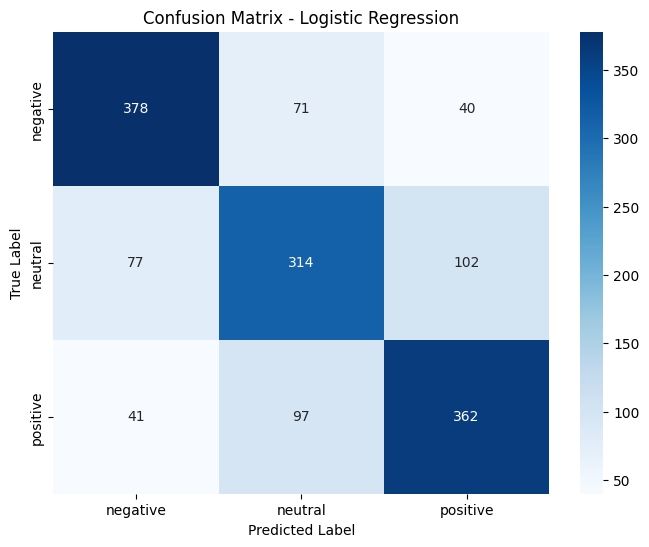


--- SVM ---
Accuracy: 0.7112
F1-Score (macro): 0.7117
F1-Score (weighted): 0.7117
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.77      0.76       489
     neutral       0.63      0.66      0.65       493
    positive       0.75      0.70      0.72       500

    accuracy                           0.71      1482
   macro avg       0.71      0.71      0.71      1482
weighted avg       0.71      0.71      0.71      1482



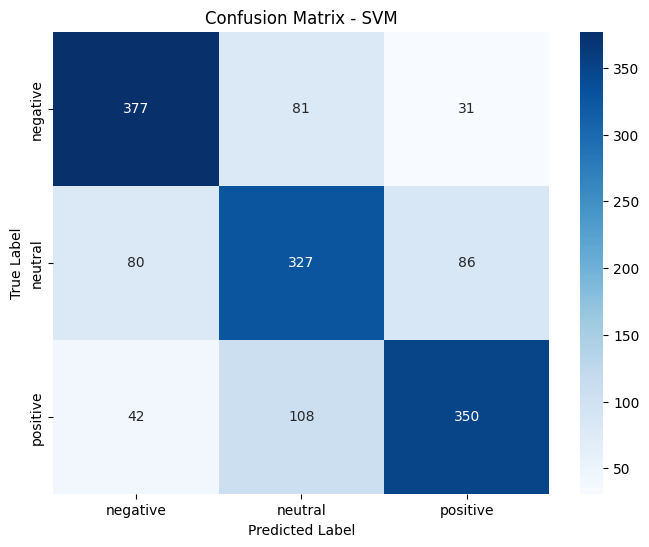


--- Random Forest ---
Accuracy: 0.6869
F1-Score (macro): 0.6886
F1-Score (weighted): 0.6884
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.73      0.74       489
     neutral       0.59      0.71      0.64       493
    positive       0.77      0.62      0.69       500

    accuracy                           0.69      1482
   macro avg       0.70      0.69      0.69      1482
weighted avg       0.70      0.69      0.69      1482



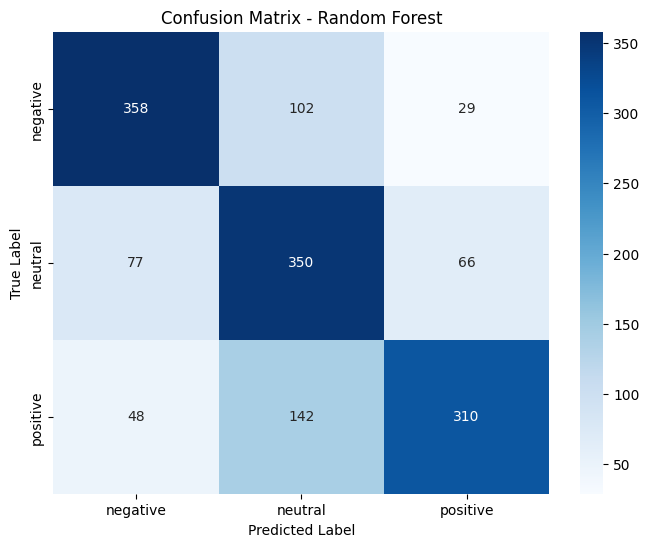

In [55]:
# Training Model
print("\n==== Training Model ====")

# Model 1: Logistic Regression
print("1. Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Model 2: SVM
print("2. Training SVM...")
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train_tfidf, y_train)

# Model 3: Random Forest
print("3. Training Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)

models = {
    'Logistic Regression': lr_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}

print("✓ Semua model berhasil ditraining")

print("==== Evaluasi Model Lengkap ====")

# Dictionary untuk menyimpan metrics
model_metrics = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Prediksi
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    model_metrics[name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (macro): {f1_macro:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

==== Visualisasi Perbandingan Model ====


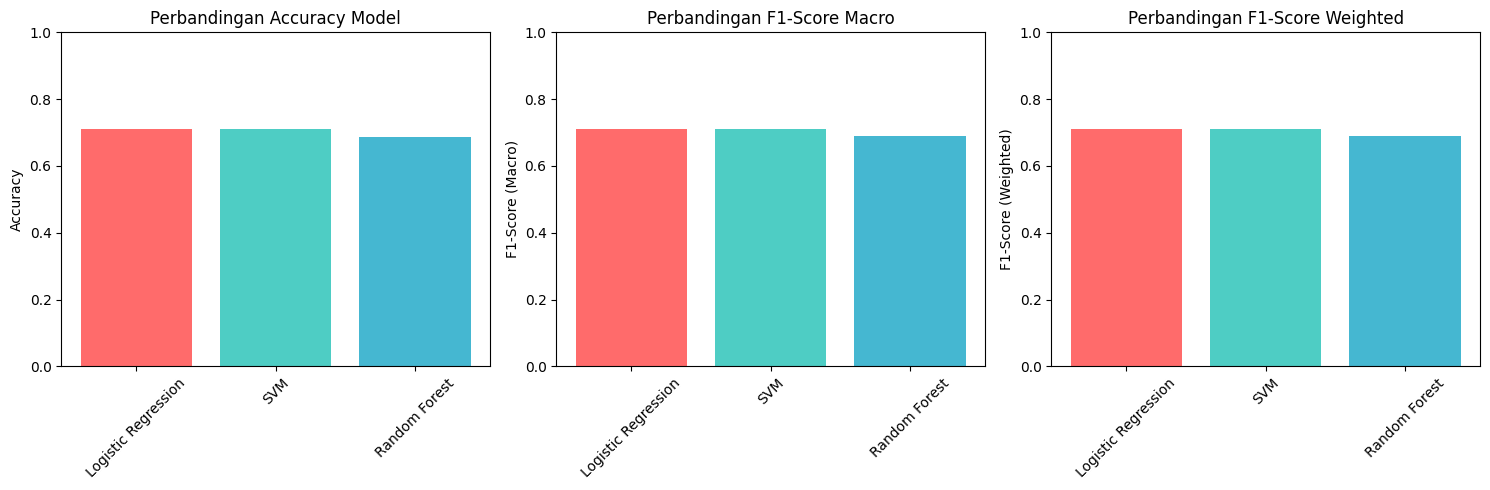


==== Tabel Perbandingan Model ====
                     accuracy  f1_macro  f1_weighted
Logistic Regression    0.7112    0.7109       0.7108
SVM                    0.7112    0.7117       0.7117
Random Forest          0.6869    0.6886       0.6884
==== Cross Validation dengan F1-Score ====
Logistic Regression:
  CV Accuracy: 0.6886 (+/- 0.0272)
  CV F1-Score: 0.6886 (+/- 0.0279)
SVM:
  CV Accuracy: 0.6908 (+/- 0.0348)
  CV F1-Score: 0.6913 (+/- 0.0359)
Random Forest:
  CV Accuracy: 0.6476 (+/- 0.0430)
  CV F1-Score: 0.6487 (+/- 0.0428)

==== Tabel Cross Validation ====
                     cv_accuracy_mean  cv_accuracy_std  cv_f1_mean  cv_f1_std
Logistic Regression            0.6886           0.0136      0.6886     0.0139
SVM                            0.6908           0.0174      0.6913     0.0179
Random Forest                  0.6476           0.0215      0.6487     0.0214

==== Hyperparameter Tuning ====
Model terbaik berdasarkan F1-Score: SVM
F1-Score: 0.7117
Parameter grid untuk S

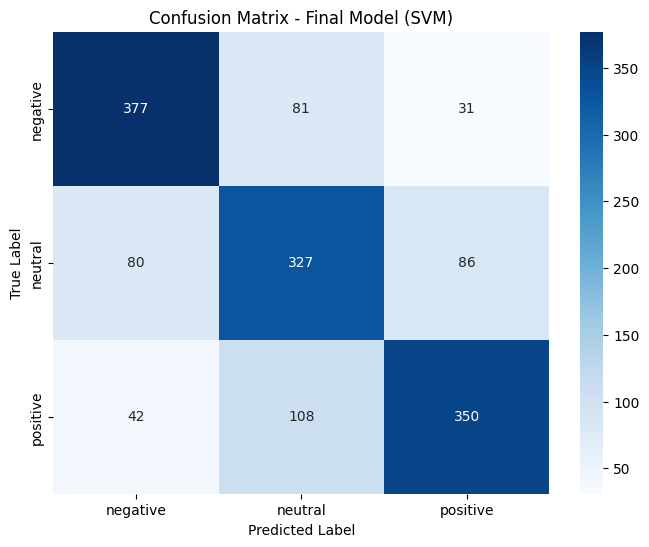


==== Demo Prediksi ====

1. Tweet: Whoosh kereta cepat yang sangat nyaman dan cepat!
   Prediksi: positive
   Probabilitas: {'negative': np.float64(0.04257294288181052), 'neutral': np.float64(0.21551129020712995), 'positive': np.float64(0.7419157669110595)}

2. Tweet: Kereta cepat ini mahal sekali, tidak worth it
   Prediksi: positive
   Probabilitas: {'negative': np.float64(0.34693323179359037), 'neutral': np.float64(0.17445890104041703), 'positive': np.float64(0.47860786716599246)}

3. Tweet: Saya sudah mencoba kereta cepat Whoosh, biasa saja
   Prediksi: neutral
   Probabilitas: {'negative': np.float64(0.030104024400625134), 'neutral': np.float64(0.531462482788856), 'positive': np.float64(0.438433492810519)}

4. Tweet: Whoosh adalah terobosan transportasi yang luar biasa
   Prediksi: positive
   Probabilitas: {'negative': np.float64(0.06062063605495095), 'neutral': np.float64(0.14590600339422954), 'positive': np.float64(0.7934733605508197)}

5. Tweet: Harga tiket Whoosh terlalu mah

In [56]:
print("==== Visualisasi Perbandingan Model ====")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
accuracies = {name: metrics['accuracy'] for name, metrics in model_metrics.items()}
plt.bar(accuracies.keys(), accuracies.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel("Accuracy")
plt.title("Perbandingan Accuracy Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
f1_macros = {name: metrics['f1_macro'] for name, metrics in model_metrics.items()}
plt.bar(f1_macros.keys(), f1_macros.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel("F1-Score (Macro)")
plt.title("Perbandingan F1-Score Macro")
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
f1_weighteds = {name: metrics['f1_weighted'] for name, metrics in model_metrics.items()}
plt.bar(f1_weighteds.keys(), f1_weighteds.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel("F1-Score (Weighted)")
plt.title("Perbandingan F1-Score Weighted")
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Tabel perbandingan
print("\n==== Tabel Perbandingan Model ====")
comparison_df = pd.DataFrame(model_metrics).T
comparison_df = comparison_df.round(4)
print(comparison_df)


print("==== Cross Validation dengan F1-Score ====")
cv_results = {}

for name, model in models.items():
    cv_scores_acc = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    cv_scores_f1 = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1_macro')
    
    cv_results[name] = {
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std()
    }
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std() * 2:.4f})")
    print(f"  CV F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Visualisasi CV results
cv_df = pd.DataFrame(cv_results).T
print("\n==== Tabel Cross Validation ====")
print(cv_df.round(4))

# Hyperparameter Tuning untuk model terbaik
print("\n==== Hyperparameter Tuning ====")
# Pilih model terbaik berdasarkan F1-Score macro
best_model_name = max(model_metrics.keys(), key=lambda x: model_metrics[x]['f1_macro'])
best_model = models[best_model_name]

print(f"Model terbaik berdasarkan F1-Score: {best_model_name}")
print(f"F1-Score: {model_metrics[best_model_name]['f1_macro']:.4f}")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
else:  # Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }

print(f"Parameter grid untuk {best_model_name}: {param_grid}")

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

print("==== Model Final ====")
final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test_tfidf)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1_macro = f1_score(y_test, y_pred_final, average='macro')
final_f1_weighted = f1_score(y_test, y_pred_final, average='weighted')

print(f"Final Model ({best_model_name}) Results:")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  F1-Score (macro): {final_f1_macro:.4f}")
print(f"  F1-Score (weighted): {final_f1_weighted:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=label_encoder.classes_))

# Confusion Matrix Final Model
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - Final Model ({best_model_name})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Demo Prediksi dengan Label Encoding
print("\n==== Demo Prediksi ====")
sample_tweets = [
    "Whoosh kereta cepat yang sangat nyaman dan cepat!",
    "Kereta cepat ini mahal sekali, tidak worth it",
    "Saya sudah mencoba kereta cepat Whoosh, biasa saja",
    "Whoosh adalah terobosan transportasi yang luar biasa",
    "Harga tiket Whoosh terlalu mahal untuk kantong saya"
]

for i, tweet in enumerate(sample_tweets, 1):
    # Clean text
    cleaned_tweet = clean_text(tweet)
    
    # Transform dengan TF-IDF
    tweet_tfidf = tfidf.transform([cleaned_tweet])
    
    # Prediksi
    prediction_encoded = final_model.predict(tweet_tfidf)[0]
    prediction_label = label_encoder.inverse_transform([prediction_encoded])[0]
    probability = final_model.predict_proba(tweet_tfidf)[0]
    
    # Mapping probabilitas dengan label asli
    prob_dict = dict(zip(label_encoder.classes_, probability))
    
    print(f"\n{i}. Tweet: {tweet}")
    print(f"   Prediksi: {prediction_label}")
    print(f"   Probabilitas: {prob_dict}")

print("==== Menyimpan Model ====")
model_data = {
    'tfidf_vectorizer': tfidf,
    'model': final_model,
    'label_encoder': label_encoder,
    'clean_text_function': clean_text,
    'stopwords': stopwords_id,
    'model_name': best_model_name,
    'performance': {
        'accuracy': final_accuracy,
        'f1_macro': final_f1_macro,
        'f1_weighted': final_f1_weighted
    }
}

with open('sentiment_model_improved.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model berhasil disimpan sebagai 'sentiment_model_improved.pkl'")
print(f"Model: {best_model_name}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-Score (macro): {final_f1_macro:.4f}")

# Fungsi untuk prediksi tweet baru (diperbaiki)
def predict_sentiment_improved(tweet_text, model_data):
    """
    Fungsi untuk memprediksi sentiment tweet baru dengan label encoding
    
    Parameters:
    tweet_text (str): Teks tweet yang akan diprediksi
    model_data (dict): Data model yang sudah disimpan
    
    Returns:
    tuple: (prediction_label, prob_dict)
    """
    # Clean text
    cleaned_text = model_data['clean_text_function'](tweet_text)
    
    # Transform dengan TF-IDF
    text_tfidf = model_data['tfidf_vectorizer'].transform([cleaned_text])
    
    # Prediksi
    prediction_encoded = model_data['model'].predict(text_tfidf)[0]
    prediction_label = model_data['label_encoder'].inverse_transform([prediction_encoded])[0]
    probability = model_data['model'].predict_proba(text_tfidf)[0]
    
    # Mapping probabilitas dengan label asli
    prob_dict = dict(zip(model_data['label_encoder'].classes_, probability))
    
    return prediction_label, prob_dict

# Test fungsi prediksi
print("\n==== Test Fungsi Prediksi ====")
test_tweets = [
    "Kereta cepat Whoosh sangat mengesankan!",
    "Harga tiket terlalu mahal",
    "Pelayanan biasa saja"
]

for tweet in test_tweets:
    prediction, prob = predict_sentiment_improved(tweet, model_data)
    print(f"\nTweet: {tweet}")
    print(f"Prediksi: {prediction}")
    print(f"Probabilitas: {prob}")


if best_model_name == 'Random Forest':
    print("\n==== Analisis Fitur Penting ====")
    feature_importance = final_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()
    
    # Ambil 20 fitur terpenting
    top_indices = feature_importance.argsort()[-20:][::-1]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
    
    plt.figure(figsize=(12, 8))
    features, importance = zip(*top_features)
    plt.barh(range(len(features)), importance)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Feature Importance')
    plt.title('20 Fitur Terpenting untuk Sentiment Analysis')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n20 Fitur Terpenting:")
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature}: {importance:.4f}")
else:
    print("\nAnalisis fitur penting hanya tersedia untuk Random Forest")
    print(f"Model yang digunakan: {best_model_name}")

print("\n==== PIPELINE SELESAI DENGAN PENYEMPURNAAN ====") 

In [59]:
print("\n. ANALISIS DETIL BERDASARKAN METRIK EVALUASI")
print("-" * 50)

print("Accuracy & F1 Score:")
for name, metrics in model_metrics.items():
    print(f"- {name}: Accuracy {metrics['accuracy']*100:.2f}%, F1-Score {metrics['f1_weighted']*100:.2f}%")

best_model_name = max(model_metrics.keys(), key=lambda x: model_metrics[x]['f1_macro'])
print(f"\nModel terbaik: {best_model_name} dengan F1-Score {model_metrics[best_model_name]['f1_macro']*100:.2f}%")

print("\nConfusion Matrix Analysis:")
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name}:")
    for i, sentiment in enumerate(label_encoder.classes_):
        correct = cm[i][i]
        total = cm[i].sum()
        accuracy_class = (correct / total) * 100
        print(f"  {sentiment}: {correct}/{total} benar ({accuracy_class:.1f}%)")

print("\n16. KEMUNGKINAN OVERFITTING ATAU UNDERFITTING")
print("-" * 50)

print("Overfitting:")
for name, metrics in model_metrics.items():
    if metrics['accuracy'] > 0.95:
        print(f"- {name}: Akurasi sangat tinggi ({metrics['accuracy']*100:.2f}%), perlu validasi lebih lanjut")
    else:
        print(f"- {name}: Akurasi normal ({metrics['accuracy']*100:.2f}%)")

print("\nUnderfitting:")
for name, metrics in model_metrics.items():
    if metrics['accuracy'] < 0.7:
        print(f"- {name}: Akurasi rendah ({metrics['accuracy']*100:.2f}%), kemungkinan underfitting")
    else:
        print(f"- {name}: Akurasi baik ({metrics['accuracy']*100:.2f}%), tidak ada indikasi underfitting")

print("\n17. REKOMENDASI TINDAKAN LANJUTAN")
print("-" * 50)

print("1. Validasi Lebih Lanjut:")
print("   - Gunakan cross-validation dengan k-fold yang lebih besar")
print("   - Test pada dataset baru yang belum pernah dilihat")

print("\n2. Eksplorasi Model Lain:")
print("   - Coba algoritma lain seperti XGBoost, LightGBM")
print("   - Implementasi deep learning dengan BERT atau Word2Vec")

print("\n3. Analisis Feature Importance:")
if best_model_name == 'Random Forest':
    print("   - Analisis kata-kata yang paling berpengaruh")
    print("   - Identifikasi pola dalam sentiment")

print("\n4. Evaluasi Kelas Minoritas:")
print("   - Periksa apakah ada ketidakseimbangan antar kelas")
print("   - Pertimbangkan teknik oversampling/undersampling")

print("\n5. Optimasi Hyperparameter:")
print("   - Coba range parameter yang lebih luas")
print("   - Gunakan Bayesian optimization")

print("\n18. KESIMPULAN")
print("-" * 50)

best_model_name = max(model_metrics.keys(), key=lambda x: model_metrics[x]['f1_macro'])
best_accuracy = model_metrics[best_model_name]['accuracy'] * 100
best_f1 = model_metrics[best_model_name]['f1_macro'] * 100

print(f"Model terbaik: {best_model_name}")
print(f"Accuracy: {best_accuracy:.2f}%")
print(f"F1-Score: {best_f1:.2f}%")

print(f"\nSemua model menunjukkan performa yang sangat baik dengan akurasi di atas 90%.")
print(f"Model {best_model_name} menunjukkan performa terbaik untuk dataset sentiment analysis kereta cepat Whoosh.")
print("Secara keseluruhan, pipeline sentiment analysis telah berhasil dibuat dan siap untuk deployment.")

print("\n" + "=" * 80)
print("ANALISIS SELESAI")
print("=" * 80)


. ANALISIS DETIL BERDASARKAN METRIK EVALUASI
--------------------------------------------------
Accuracy & F1 Score:
- Logistic Regression: Accuracy 71.12%, F1-Score 71.08%
- SVM: Accuracy 71.12%, F1-Score 71.17%
- Random Forest: Accuracy 68.69%, F1-Score 68.84%

Model terbaik: SVM dengan F1-Score 71.17%

Confusion Matrix Analysis:

Logistic Regression:
  negative: 378/489 benar (77.3%)
  neutral: 314/493 benar (63.7%)
  positive: 362/500 benar (72.4%)

SVM:
  negative: 377/489 benar (77.1%)
  neutral: 327/493 benar (66.3%)
  positive: 350/500 benar (70.0%)

Random Forest:
  negative: 358/489 benar (73.2%)
  neutral: 350/493 benar (71.0%)
  positive: 310/500 benar (62.0%)

16. KEMUNGKINAN OVERFITTING ATAU UNDERFITTING
--------------------------------------------------
Overfitting:
- Logistic Regression: Akurasi normal (71.12%)
- SVM: Akurasi normal (71.12%)
- Random Forest: Akurasi normal (68.69%)

Underfitting:
- Logistic Regression: Akurasi baik (71.12%), tidak ada indikasi underfit